In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numpy.linalg import solve

## bess_laplace_ramps.py
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Dict, Tuple
from scipy.stats import lognorm

import importlib
# --- Core code helpers ---
import src.core_helpers
importlib.reload(src.core_helpers)
from src.core_helpers import *

# --- Core Synthetic data ---
import src.core_SynData
importlib.reload(src.core_SynData)
from src.core_SynData import *

# --- Solvers ---
import src.core_Solvers
importlib.reload(src.core_Solvers)
from src.core_Solvers import *

# --- Figures ---
import src.core_Figures
importlib.reload(src.core_Figures)
from src.core_Figures import *

# --- Parametric moments ---
import src.core_Moments
importlib.reload(src.core_Moments)
from src.core_Moments import *

# --- Energy Solvers ---
import src.core_ESolvers
importlib.reload(src.core_ESolvers)
from src.core_ESolvers import *

### PARAMETERS

In [2]:
VKU_Pmax = 126      # [MW]
VKU_beta_GL = 0.6196
VKU_beta_SL = 0.7157
s_ratio = (1/VKU_beta_SL) / VKU_Pmax
print(f"s_ratio: {s_ratio}")

# --- Simulation Parameters ---
N = 1000000
grid = 1001
r = 0.01*60                 # 1/HR
tau = 0.0 
dt = 1/60                   # 1/HR
beta = 0.6               # min/MW
Pmax = (1/beta)/s_ratio
alpha = r*Pmax           # MW/HR]

a = alpha * dt           # MW
a_tilde = beta * a
print(f"Pmax: {Pmax}")
print(f"alpha value: {alpha} \na value: {a} \na_tilde value: {a_tilde}")

# --- Parameters for infinity limit ---
Pmax_inf = 10000000

# --- Simulation grid for P99 figures ---
r_values = np.linspace(0.1, 3.5, 50) / (beta * Pmax)    # [1/MIN]
alpha_values = r_values*60*Pmax                       # [MW/HR] (ALPHA)
a_values = alpha_values * dt                          # [MW/MIN]
a_tilde_values = beta * a_values
print(f"min(alpha_values): {min(alpha_values)}, max(alpha_values): {max(alpha_values)}")
print(f"min(a_values): {min(a_values)}, max(alpha_values): {max(a_values)}")
print(f"min(a_values): {min(a_tilde_values)}, max(a_values): {max(a_tilde_values)}")

s_ratio: 0.011089154585032747
Pmax: 150.297
alpha value: 90.17819999999999 
a value: 1.50297 
a_tilde value: 0.9017819999999999
min(alpha_values): 10.000000000000002, max(alpha_values): 350.00000000000006
min(a_values): 0.16666666666666669, max(alpha_values): 5.833333333333334
min(a_values): 0.1, max(a_values): 3.5000000000000004


### ALVARO SYNTHETIC DATA

In [130]:
"""# ---------- Laplace helpers ----------
def laplace_cdf(y: np.ndarray | float, b: float) -> np.ndarray | float:
    y = np.asarray(y)
    return np.where(
        y <= 0.0,
        0.5 * np.exp(y / b),
        1.0 - 0.5 * np.exp(-y / b)
    )

def laplace_ppf(p: np.ndarray | float, b: float) -> np.ndarray | float:
    p = np.asarray(p)
    if np.any((p <= 0) | (p >= 1)):
        raise ValueError("p must be in (0,1)")
    return np.where(
        p <= 0.5,
        b * np.log(2.0 * p),
        -b * np.log(2.0 * (1.0 - p))
    )

def b_from_abs_quantile(q_abs: float, p: float = 0.95) -> float:
    if not (0.0 < p < 1.0):
        raise ValueError("p must be in (0,1)")
    return q_abs / np.log(1.0 / (1.0 - p))

# ---------- Truncated-Laplace sampler ----------
def sample_trunc_laplace(a: float, c: float, b: float, rng: np.random.Generator) -> float:
    if a > c:
        raise ValueError("Invalid truncation interval: a > c")
    Fa = laplace_cdf(a, b)
    Fc = laplace_cdf(c, b)
    width = Fc - Fa
    if width <= 1e-14:
        # Interval is extremely tight; return midpoint (numerically stable fallback)
        return 0.5 * (a + c)
    u = rng.random()
    p = Fa + u * width
    return float(laplace_ppf(p, b))

# ---------- Simulation ----------
@dataclass
class SimConfig:
    N: int = 288               # number of steps (e.g., one day at 5-min resolution)
    P_max: float = 100.0       # MW
    P0: float = 60.0           # MW initial power
    b: float = 2.5             # Laplace scale in MW/step (≈ E|Y|)
    R_max: float | None = None # optional hard ramp cap MW/step (e.g., 15.0)
    seed: int = 42

def simulate_Y_P(cfg: SimConfig) -> tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(cfg.seed)
    Y = np.empty(cfg.N, dtype=float)
    P = np.empty(cfg.N + 1, dtype=float)
    P[0] = float(cfg.P0)

    for n in range(cfg.N):
        # Feasible bounds from power limits
        L = -P[n]                 # can't go below 0
        U = cfg.P_max - P[n]      # can't exceed P_max
        # Optional hard per-step ramp cap
        if cfg.R_max is not None:
            L = max(L, -cfg.R_max)
            U = min(U,  cfg.R_max)
        # Guard if interval collapses (e.g., at exact boundary with tight cap)
        if U < L:
            # Numerical safeguard; set no movement
            y = 0.0
        else:
            y = sample_trunc_laplace(L, U, cfg.b, rng)
        Y[n] = y
        P[n + 1] = P[n] + y

    return Y, P

cfg = SimConfig(
    N=N,          # 24h at 5-min steps * 30
    P_max=Pmax,    # 100 MW wind farm
    P0=50.0,        # start 
    b=beta, #0.7157,  #AQUI BETA 1/BETA OP
    R_max=None,     
    seed=7
)
Y, P = simulate_Y_P(cfg)"""

'# ---------- Laplace helpers ----------\ndef laplace_cdf(y: np.ndarray | float, b: float) -> np.ndarray | float:\n    y = np.asarray(y)\n    return np.where(\n        y <= 0.0,\n        0.5 * np.exp(y / b),\n        1.0 - 0.5 * np.exp(-y / b)\n    )\n\ndef laplace_ppf(p: np.ndarray | float, b: float) -> np.ndarray | float:\n    p = np.asarray(p)\n    if np.any((p <= 0) | (p >= 1)):\n        raise ValueError("p must be in (0,1)")\n    return np.where(\n        p <= 0.5,\n        b * np.log(2.0 * p),\n        -b * np.log(2.0 * (1.0 - p))\n    )\n\ndef b_from_abs_quantile(q_abs: float, p: float = 0.95) -> float:\n    if not (0.0 < p < 1.0):\n        raise ValueError("p must be in (0,1)")\n    return q_abs / np.log(1.0 / (1.0 - p))\n\n# ---------- Truncated-Laplace sampler ----------\ndef sample_trunc_laplace(a: float, c: float, b: float, rng: np.random.Generator) -> float:\n    if a > c:\n        raise ValueError("Invalid truncation interval: a > c")\n    Fa = laplace_cdf(a, b)\n    Fc =

### BESS SIZING DATA

In [3]:
# --- Taking P0 -> infinity ---
rng = np.random.default_rng(7)
seed = rng.random(N)
Y, P = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)

### MOMENTS

In [140]:
"""# Shifted Laplace X = -Y - a
def f_X_A(x):
    x = np.asarray(x)
    return 0.5*beta*np.exp(-beta*np.abs(x + a))

def F_X_A(x):
    x = np.asarray(x)
    z = x + a
    out = np.empty_like(z, dtype=float)
    m = (z < 0)
    out[m]  = 0.5*np.exp(beta*z[m])
    out[~m] = 1 - 0.5*np.exp(-beta*z[~m])
    return out

# z - grid and Nystrom Kernel construction
z_max, N = 40.0, 1000                            # Grid over possible entrance heights, can adjust dependeing on 'a' (lower "a" increases the b_max) 
z_grid = np.linspace(0.0, z_max, N+1)
w = np.ones_like(z_grid); w[0]=w[-1]=0.5
h = z_grid[1] - z_grid[0]

Zij = z_grid[None, :] - z_grid[:, None]          # b_j - z_i
K   = h * f_X_A(Zij) * w[None, :]                  # (N+1)x(N+1) kernel
Fvec = F_X_A(-z_grid)                              # boundary F_X(-z)

# Entrance mixture normalization factor Φ(λ) 
Ppos = 1.0 - F_X_A(0.0)                            

# Conditional Moments via operator equations 
I  = np.eye(z_grid.size)
m1 = solve(I - K, dt * z_grid)
m2 = solve(I - K, 2 * dt * z_grid * m1 - (dt*z_grid)**2)

# Global moments with mixture
def mix_mu(vec): 
    return (h * np.sum(w * vec * f_X_A(z_grid))) / Ppos

E1, E2 = mix_mu(m1), mix_mu(m2)
print("Moments:")
print(f"E[E]   = {E1:.6f}")
print(f"E[E^2] = {E2:.6f}")"""

'# Shifted Laplace X = -Y - a\ndef f_X_A(x):\n    x = np.asarray(x)\n    return 0.5*beta*np.exp(-beta*np.abs(x + a))\n\ndef F_X_A(x):\n    x = np.asarray(x)\n    z = x + a\n    out = np.empty_like(z, dtype=float)\n    m = (z < 0)\n    out[m]  = 0.5*np.exp(beta*z[m])\n    out[~m] = 1 - 0.5*np.exp(-beta*z[~m])\n    return out\n\n# z - grid and Nystrom Kernel construction\nz_max, N = 40.0, 1000                            # Grid over possible entrance heights, can adjust dependeing on \'a\' (lower "a" increases the b_max) \nz_grid = np.linspace(0.0, z_max, N+1)\nw = np.ones_like(z_grid); w[0]=w[-1]=0.5\nh = z_grid[1] - z_grid[0]\n\nZij = z_grid[None, :] - z_grid[:, None]          # b_j - z_i\nK   = h * f_X_A(Zij) * w[None, :]                  # (N+1)x(N+1) kernel\nFvec = F_X_A(-z_grid)                              # boundary F_X(-z)\n\n# Entrance mixture normalization factor Φ(λ) \nPpos = 1.0 - F_X_A(0.0)                            \n\n# Conditional Moments via operator equations \nI  = np

### BESS SIZING MOMENTS

In [4]:
# Build Nyström matrices I, K and z_grid
z_max = 40.0
I, K, z_grid, w, h = Nystrom(
    z_max=z_max,
    N=grid,
    kernel_pdf=lambda delta: f_X(delta, beta, a),    # delta = b_j - z_i
)

# CONDITIONAL MOMENTS CALCULATION
m1 = solve(I - K, dt * z_grid)
m2 = solve(I - K, 2.0 * dt * z_grid * m1 - (dt * z_grid) ** 2)

# ENTRANCE MIXTURE: GLOBAL MOMENTS
Ppos = 1.0 - F_X(0.0, beta=beta, a=a)
pdf_grid = f_X(z_grid, beta=beta, a=a)

E1 = GM_mix(m1, w, h, pdf_grid, Ppos)
E2 = GM_mix(m2, w, h, pdf_grid, Ppos)

print("Moments:")
print(f"E[E]   = {E1:.6f}")
print(f"E[E^2] = {E2:.6f}")

Moments:
E[E]   = 0.097417
E[E^2] = 0.062685


### ENERGY RAMPS

In [5]:
@njit(cache=True)
def Energy_ramps(Y, a, dt):
    N = Y.size
    B = np.zeros(N + 1, dtype=np.float64)
    energies = np.empty(N // 2 + 2, dtype=np.float64)
    n_ener = 0

    in_ramp = False
    ramp_energy_acc = 0.0

    for n in range(N):
        b_next = B[n] + (-Y[n] - a)
        if b_next < 0.0:
            b_next = 0.0
        B[n + 1] = b_next

        if not in_ramp:
            if b_next > 0.0:
                in_ramp = True
                ramp_energy_acc = b_next
        else:
            ramp_energy_acc += b_next
            if b_next == 0.0:
                energies[n_ener] = dt * ramp_energy_acc
                n_ener += 1
                in_ramp = False

    return B, energies[:n_ener]
B, energies = Energy_ramps(Y, a, dt)
mu  = (E1)
m2  = (E2)
moments = [mu, m2]
print("Number of ramps: ", len(energies))

Number of ramps:  137411


### Algorithmic solution

In [6]:
def histogram(values: np.ndarray, n_bins: int) -> Tuple[np.ndarray, np.ndarray]:
    vmin = np.min(values)
    vmax = np.max(values)

    # Create edges: length n_bins + 1
    if vmax == vmin:
        edges = np.linspace(vmin, vmax + 1.0, n_bins + 1)
    else:
        edges = np.linspace(vmin, vmax, n_bins + 1)

    counts = np.zeros(n_bins, dtype=np.float64)

    # Fill counts
    for v in values:
        if vmax == vmin:
            idx = 0
        else:
            t = (v - vmin) / (vmax - vmin)
            idx = int(t * n_bins)
            if idx == n_bins:
                idx = n_bins - 1
        counts[idx] += 1.0

    bin_width = edges[1] - edges[0]

    density = counts / (values.size * bin_width)

    # centers: length n_bins
    centers = 0.5 * (edges[:-1] + edges[1:])

    return density, centers

f_sim, e_sim = histogram(energies, 1000)

In [7]:
def dist_grid(x: np.ndarray, n: int = 1000, qmin: float = 0.001, qmax: float = 0.999999) -> np.ndarray:
    x = np.asarray(x, dtype=float)

    lo = 0.0
    if np.all(np.isfinite(x)):
        lo = max(0.0, float(np.quantile(x, qmin)))

    hi = float(np.quantile(x, qmax))
    if (not np.isfinite(hi)) or (hi <= lo):
        xmax = float(np.max(x))
        hi = xmax if np.isfinite(xmax) else 1.0
        if hi <= lo:
            hi = lo + 1.0

    return np.geomspace(lo, hi, n)

@dataclass
class LN2Params:
    mu: float
    sigma: float  # > 0

def fit_lognormal_2p_from_moments(m1: float, m2: float) -> LN2Params:
    if m1 <= 0.0 or m2 <= 0.0 or m2 <= m1 * m1:
        raise ValueError("Moments invalid for 2P lognormal (need m1>0 and variance>0).")
    sigma2 = float(np.log(m2 / (m1 * m1)))
    return LN2Params(mu=float(np.log(m1) - 0.5 * sigma2), sigma=float(np.sqrt(sigma2)))

def compare_fit_lognormal(energies: np.ndarray, moments: Sequence[float], bins: int = 500):
    e = np.asarray(energies, dtype=float)
    e = e[np.isfinite(e) & (e >= 0.0)]

    ln2 = fit_lognormal_2p_from_moments(float(moments[0]), float(moments[1]))

    xg = dist_grid(e, n=1000)
    rv = lognorm(s=ln2.sigma, scale=np.exp(ln2.mu), loc=0.0)

    return bins, xg, rv.pdf(xg), rv.cdf(xg), ln2

C:\Users\Diego\AppData\Local\Temp\ipykernel_10544\2785367564.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


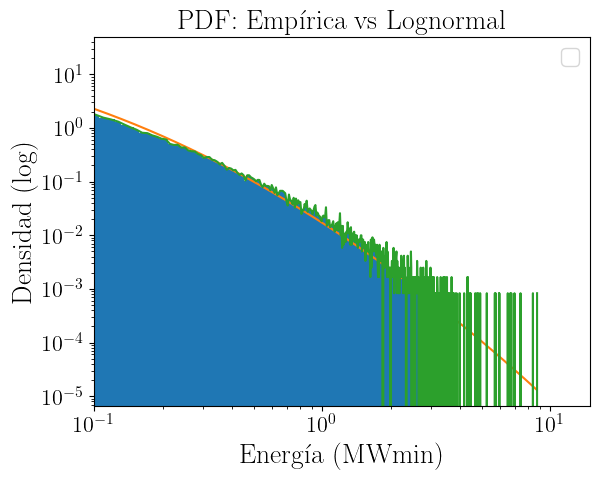

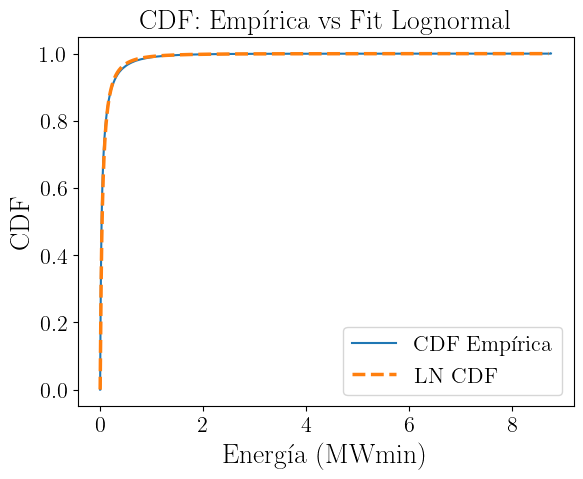

In [8]:
def _ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    x = np.sort(np.asarray(x))
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

bins, xg, pdf2, cdf2, ln2 = compare_fit_lognormal(energies, moments[:2])

plt.figure()
plt.hist(energies, bins=1000, density=True)
plt.plot(xg, pdf2)
plt.plot(e_sim, f_sim)
plt.xlabel("Energía (MWmin)")
plt.ylabel("Densidad (log)")
plt.title("PDF: Empírica vs Lognormal")
plt.xlim(1e-1, 15)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

xe, Fe = _ecdf(energies)
plt.figure()
plt.plot(xe, Fe, drawstyle="steps-post", label="CDF Empírica")
plt.plot(xg, cdf2, lw=2.5, ls="--", label="LN CDF")
plt.xlabel("Energía (MWmin)"); plt.ylabel("CDF"); plt.title("CDF: Empírica vs Fit Lognormal")
#plt.xscale("log")
plt.legend()
